In [1]:
import os
import sys

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from einops import rearrange

sys.path.append("..")
import matplotlib.pyplot as plt

# Plotting imports
import seaborn as sns

import slowfast.datasets.utils as data_utils
from slowfast.datasets.loader import construct_loader

# Slowfast imports
from slowfast.models import build_model
from slowfast.utils.checkpoint import load_checkpoint
from slowfast.utils.parser import alt_parse_args, load_config

/home/kukushkin/miniconda3/envs/env/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/kukushkin/miniconda3/envs/env/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
behaviours_file = "../dataset/metadata/behaviours.txt"

with open(behaviours_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

In [3]:
bg_model_path = "/home/kukushkin/imslowfast/weights/model=slow_r50_bg-only_rm-bg_e300.pyth"  # "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/weights/bg-only/model=slow_r50_bg-only_e300.pyth"
bl_model_path = "/home/kukushkin/imslowfast/weights/model=slow_r50_baseline_e300.pyth"
# "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/weights/model=slow-r50_w-negatives_epoch=001.pyth"
# r50_model_path = (
#     "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/SLOWONLY_8x8_R50.pkl"
# )

cfg_path = "/home/kukushkin/imslowfast/configs/SLOW_8x8_R50_Local (1).yaml"

In [4]:
def alt_load_config(cfg_path):
    args = alt_parse_args()[:-1]
    cfg = load_config(
        args[0],
        path_to_config=cfg_path,
    )
    return cfg

In [5]:
def load_model(cfg_path, ckpt_path, map_location="cpu", ckpt_type="pytorch"):
    # Load model config
    cfg = alt_load_config(cfg_path)
    model = build_model(cfg)
    if ckpt_type == "pytorch":
        checkpoint = torch.load(ckpt_path, map_location=map_location)
        model.load_state_dict(checkpoint["model_state"])
    elif ckpt_type == "caffe2":
        load_checkpoint(
            path_to_checkpoint=ckpt_path,
            model=model,
            convert_from_caffe2=True,
            data_parallel=False,
        )
    else:
        raise ValueError("Invalid checkpoint type. Choose 'pytorch' or 'caffe2'")
    return model

In [6]:
def get_feature_maps(model, inputs):
    model.eval()
    # Ensure model and inputs are on cuda if available
    if torch.cuda.is_available():
        model = model.cuda()
        inputs[0] = inputs[0].cuda()
    with torch.no_grad():
        return model.s5(model.s4(model.s3(model.s2(model.s1([inputs[0]])))))[0]

In [7]:
def get_video_frames(video_name):
    # Get original video
    video_path = "../dataset/videos/"

    batch_frames = []

    for path in video_name:
        cap = cv2.VideoCapture(os.path.join(video_path, path))
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (256, 256))
            frames.append(frame)

        batch_frames.append(np.stack(frames))

    return np.stack(batch_frames)

In [8]:
def return_spatial_cam(
    feature_conv, weight_softmax, class_idx, size_upsample=(256, 256), normalise=False
):
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h * w)))
        cam = cam.reshape(h, w)
        # Min max normalization
        if normalise:
            cam = cam - np.min(cam)
            cam_img = cam / np.max(cam)
            cam_img = np.uint8(255 * cam_img)
            cam = cam_img
        if size_upsample is not None:
            cam = cv2.resize(cam, size_upsample)
        output_cam.append(cam)
    return np.stack(output_cam)


def return_spatio_temporal_cam(
    feature_conv,
    weight_softmax,
    class_idx,
    size_upsample=(256, 256),
    normalise=False,
):
    # generate the class activation maps upsample to 256x256
    bsz, nc, t, h, w = feature_conv.shape
    batch_cam = []
    for batch in range(bsz):
        spatio_temporal_cam = []
        for t_step in range(t):
            spatial_cam = []
            spatial_conv = feature_conv[batch, :, t_step, :, :].unsqueeze(0)
            spatial_cam = return_spatial_cam(
                spatial_conv, weight_softmax, class_idx, size_upsample, normalise
            )
            spatio_temporal_cam.append(spatial_cam)
        batch_cam.append(spatio_temporal_cam)
    return np.stack(batch_cam)

In [9]:
def plot_frames_grid(frames, batch_index=0, start_frame=0, title=None):
    """
    Plot frames in a 4x4 grid.

    :param frames: Array of shape (b, t, h, w, c)
    :param batch_index: Index of the batch to use (default 0)
    :param start_frame: Starting frame index (default 0)
    :param title: Title for the entire figure (optional)
    """
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    fig.suptitle(title, fontsize=16, y=1.02) if title else None

    for i in range(4):
        for j in range(4):
            frame_index = start_frame + i * 4 + j
            if frame_index < frames.shape[1]:
                frame = frames[batch_index, frame_index]

                axes[i, j].imshow(frame)
                axes[i, j].axis("off")
                axes[i, j].set_title(f"Frame {frame_index}")
            else:
                axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

In [10]:
bg_model = load_model(cfg_path, bg_model_path)
bl_model = load_model(cfg_path, bl_model_path)

bg_classifier = bg_model.head.projection
bl_classifier = bl_model.head.projection

In [11]:
nkinetics_cfg_path = "/home/kukushkin/imslowfast/configs/SLOW_8x8_R50_FGBG_Local.yaml"
cfg = alt_load_config(nkinetics_cfg_path)
loader = construct_loader(alt_load_config(nkinetics_cfg_path), "train")

SAMPLING.BALANCED: False; BALANCE_TYPE: None


In [12]:
inputs, labels, index, time, meta = next(iter(loader))

/home/kukushkin/imslowfast/notebooks/../slowfast/datasets/decoder.py:335: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  video_tensor = torch.from_numpy(np.frombuffer(video_handle, dtype=np.uint8))
/home/kukushkin/imslowfast/notebooks/../slowfast/datasets/decoder.py:335: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppres

**Assert spatial and spatio-temporal CAMs are equivalent**

In [13]:
# Walk through CAM calculation and logit generation
batch_frames = get_video_frames(meta["fg_video_name"])

fg_feature_maps = get_feature_maps(bl_model, inputs["fg_frames"])
bg_feature_maps = get_feature_maps(bg_model, inputs["fg_frames"])

# Spatial feature map for frame 0
fg_spatial_map = fg_feature_maps[:, :, 0, :, :]

fg_spatial_cams = return_spatial_cam(
    fg_spatial_map.detach().cpu(),
    bg_classifier.weight.detach().cpu().numpy(),
    torch.linspace(0, 13, steps=14).int(),
)

fg_spatio_temporal_cams = return_spatio_temporal_cam(
    fg_feature_maps.detach().cpu(),
    bg_classifier.weight.detach().cpu().numpy(),
    torch.linspace(0, 13, steps=14).int(),
).squeeze(0)

print(fg_spatial_cams.shape, fg_spatio_temporal_cams.shape)

assert np.all(fg_spatial_cams[0] == fg_spatio_temporal_cams[0][0])

fg_spatial_logits = (
    F.adaptive_avg_pool2d(torch.tensor(fg_spatial_cams), 1).squeeze(-1).squeeze(-1)
)

# Only for the first frame
fg_spatio_temporal_logits = (
    F.adaptive_avg_pool2d(torch.tensor(fg_spatio_temporal_cams[0]), 1)
    .squeeze(-1)
    .squeeze(-1)
)

assert np.all(fg_spatial_logits.numpy() == fg_spatio_temporal_logits.numpy())

# we can interpret each element as an attribution score at (t, h, w) contributing to the logit
fg_spatio_temporal_cams = rearrange(
    torch.tensor(fg_spatio_temporal_cams).unsqueeze(0), "b t c h w -> b c t h w"
)

logits = (
    F.adaptive_avg_pool3d(torch.tensor(fg_spatio_temporal_cams.squeeze(0)), 1)
    .squeeze(-1)
    .squeeze(-1)
    .squeeze(-1)
)

assert len(logits) == 14

(14, 256, 256) (16, 14, 256, 256)


/tmp/ipykernel_62015/2664335004.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h * w)))
/tmp/ipykernel_62015/3019288094.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.adaptive_avg_pool3d(torch.tensor(fg_spatio_temporal_cams.squeeze(0)), 1)


In [15]:
def extract_framewise_features(feature_map, t):
    spatially_pooled = F.adaptive_avg_pool3d(feature_map, (t, 1, 1))
    frame_wise_features = torch.flatten(spatially_pooled, start_dim=2)
    return frame_wise_features


def get_framewise_logits(framewise_features, classifier):
    frame_wise_logits = []
    for feat in framewise_features:
        frame_wise_logits.append((classifier(feat).detach()))
    return torch.stack(frame_wise_logits)


video_features = F.adaptive_avg_pool3d(fg_feature_maps, (1, 1, 1))
video_features = torch.flatten(video_features, start_dim=1)
video_logits = torch.sigmoid(bl_classifier(video_features)).detach().cpu().numpy()

framewise_features = extract_framewise_features(fg_feature_maps, t=16)
framewise_logits = get_framewise_logits(
    framewise_features.permute(0, 2, 1), bl_classifier
)

**Plot CAMs**

/home/kukushkin/imslowfast/notebooks/../slowfast/datasets/decoder.py:335: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  video_tensor = torch.from_numpy(np.frombuffer(video_handle, dtype=np.uint8))
/home/kukushkin/imslowfast/notebooks/../slowfast/datasets/decoder.py:335: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppres

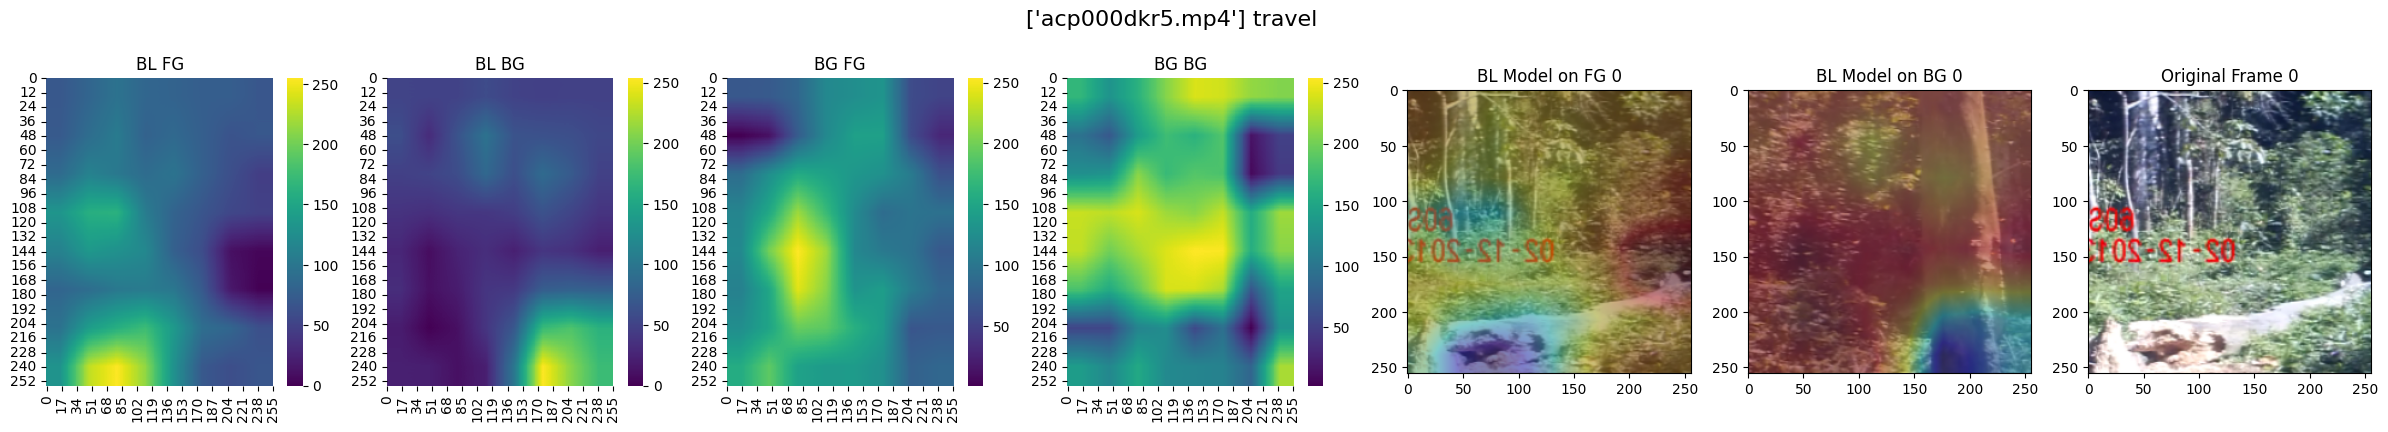

/tmp/ipykernel_62015/2664335004.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h * w)))
/tmp/ipykernel_62015/223958321.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fg_frame), cfg.DATA.MEAN, cfg.DATA.STD
/tmp/ipykernel_62015/223958321.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(bg_frame), cfg.DATA.MEAN, cfg.DATA.STD


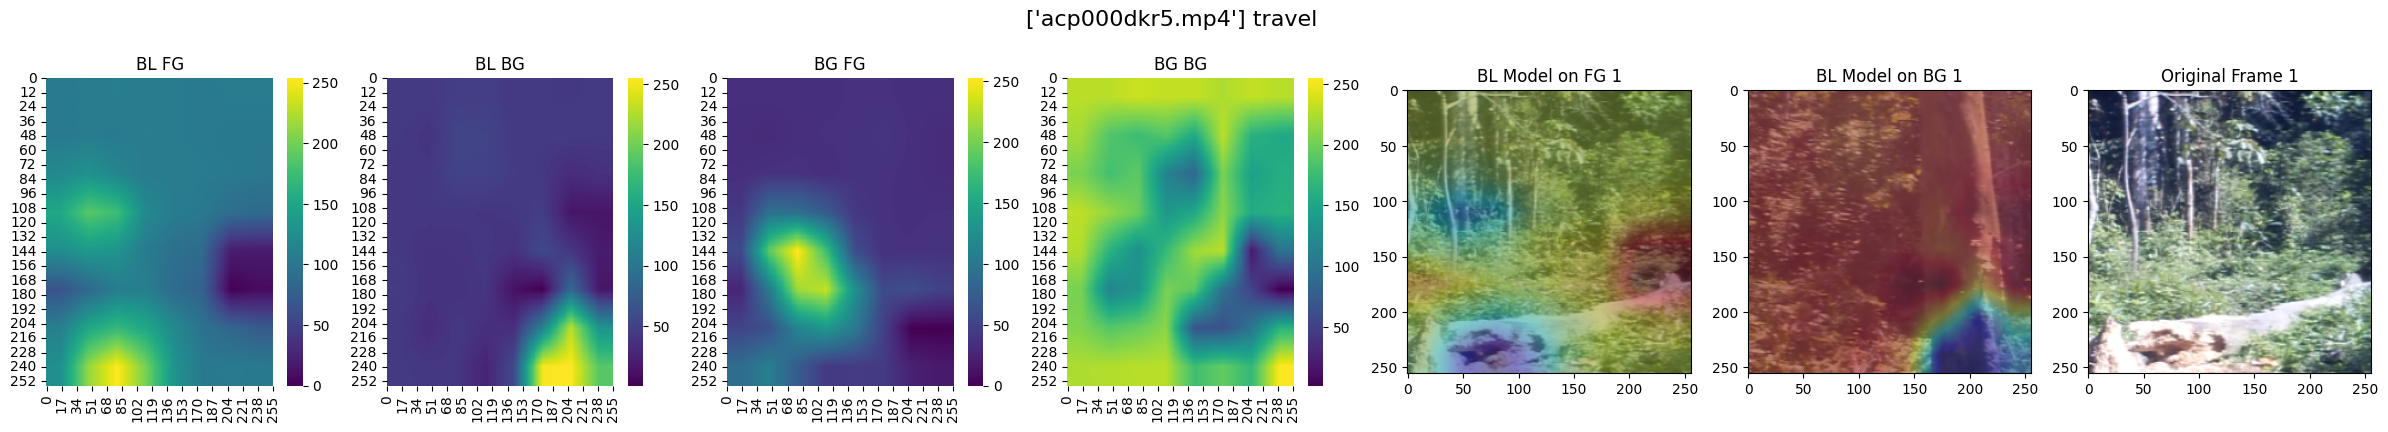

/tmp/ipykernel_62015/2664335004.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h * w)))
/tmp/ipykernel_62015/223958321.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fg_frame), cfg.DATA.MEAN, cfg.DATA.STD
/tmp/ipykernel_62015/223958321.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(bg_frame), cfg.DATA.MEAN, cfg.DATA.STD


In [16]:
all_behaviours = False
normalise = True
size_upsample = (256, 256)

for inputs, labels, index, time, meta in loader:
    # Get video frames
    fg_batch_frames = inputs["fg_frames"][0]
    bg_batch_frames = inputs["bg_frames"][0]

    fg_batch_frames = F.interpolate(
        fg_batch_frames, size=(16, 256, 256), mode="nearest"
    )
    bg_batch_frames = F.interpolate(
        bg_batch_frames, size=(16, 256, 256), mode="nearest"
    )

    # Get behaviours from the labels
    if all_behaviours:
        label_idxs = range(len(behaviours))
    else:
        label_idxs = labels[0].nonzero().squeeze().tolist()
        if isinstance(label_idxs, int):
            label_idxs = [label_idxs]

    bl_fg_feature_maps = get_feature_maps(bl_model, inputs["fg_frames"])
    bl_bg_feature_maps = get_feature_maps(bl_model, inputs["bg_frames"])

    bg_fg_feature_maps = get_feature_maps(bg_model, inputs["fg_frames"])
    bg_bg_feature_maps = get_feature_maps(bg_model, inputs["bg_frames"])

    for frame_idx in range(16):

        bl_fg_spatial_map = bl_fg_feature_maps[
            :, :, frame_idx, :, :
        ]  # bsz must be equal to 1

        bl_bg_spatial_map = bl_bg_feature_maps[
            :, :, frame_idx, :, :
        ]  # bsz must be equal to 1

        bg_fg_spatial_map = bg_fg_feature_maps[
            :, :, frame_idx, :, :
        ]  # bsz must be equal to 1

        bg_bg_spatial_map = bg_bg_feature_maps[
            :, :, frame_idx, :, :
        ]  # bsz must be equal to 1

        bl_fg_cams = return_spatial_cam(
            bl_fg_spatial_map.detach().cpu(),
            bg_classifier.weight.detach().cpu().numpy(),
            torch.linspace(0, 13, steps=14).int(),
            normalise=normalise,
            size_upsample=size_upsample,
        )

        bl_bg_cams = return_spatial_cam(
            bl_bg_spatial_map.detach().cpu(),
            bg_classifier.weight.detach().cpu().numpy(),
            torch.linspace(0, 13, steps=14).int(),
            normalise=normalise,
            size_upsample=size_upsample,
        )

        bg_fg_cams = return_spatial_cam(
            bg_fg_spatial_map.detach().cpu(),
            bg_classifier.weight.detach().cpu().numpy(),
            torch.linspace(0, 13, steps=14).int(),
            normalise=normalise,
            size_upsample=size_upsample,
        )

        bg_bg_cams = return_spatial_cam(
            bg_bg_spatial_map.detach().cpu(),
            bg_classifier.weight.detach().cpu().numpy(),
            torch.linspace(0, 13, steps=14).int(),
            normalise=normalise,
            size_upsample=size_upsample,
        )

        for l in label_idxs:

            behaviour_idx = behaviours.index(behaviours[l])

            # Increase the figure height to accommodate the main title
            fig, ax = plt.subplots(1, 7, figsize=(30, 4))

            # Baseline Model heatmap
            bl_fg_cam = bl_fg_cams[behaviour_idx]
            sns.heatmap(bl_fg_cam, ax=ax[0], cbar=True, cmap="viridis")
            ax[0].set_title("BL FG")

            bl_bg_cam = bl_bg_cams[behaviour_idx]
            sns.heatmap(bl_bg_cam, ax=ax[1], cbar=True, cmap="viridis")
            ax[1].set_title("BL BG")

            bg_fg_cam = bg_fg_cams[behaviour_idx]
            sns.heatmap(bg_fg_cam, ax=ax[2], cbar=True, cmap="viridis")
            ax[2].set_title("BG FG")

            bg_bg_cam = bg_bg_cams[behaviour_idx]
            sns.heatmap(bg_bg_cam, ax=ax[3], cbar=True, cmap="viridis")
            ax[3].set_title("BG BG")

            # Plot the bl model on fg frame
            fg_frame = fg_batch_frames[0][
                :,
                frame_idx,
                :,
            ].permute(1, 2, 0)

            fg_frame = data_utils.revert_tensor_normalize(
                torch.tensor(fg_frame), cfg.DATA.MEAN, cfg.DATA.STD
            ).numpy()

            fg_frame = np.uint8(fg_frame * 255)

            height, width, _ = fg_frame.shape
            bl_fg_cam = cv2.applyColorMap(
                cv2.resize(bl_fg_cam.astype(np.uint8), (width, height)),
                cv2.COLORMAP_JET,
            )
            result = bl_fg_cam * 0.3 + fg_frame * 0.5
            ax[4].imshow((result).astype(np.uint8))
            ax[4].set_title(f"BL Model on FG {frame_idx}")

            # Plot the bl model on bg frame
            bg_frame = bg_batch_frames[0][
                :,
                frame_idx,
                :,
            ].permute(1, 2, 0)

            bg_frame = data_utils.revert_tensor_normalize(
                torch.tensor(bg_frame), cfg.DATA.MEAN, cfg.DATA.STD
            ).numpy()

            bg_frame = np.uint8(255 * bg_frame)

            height, width, _ = bg_frame.shape
            bl_bg_cam = cv2.applyColorMap(
                cv2.resize(bl_bg_cam.astype(np.uint8), (width, height)),
                cv2.COLORMAP_JET,
            )
            result = bl_bg_cam * 0.3 + bg_frame * 0.5
            ax[5].imshow((result).astype(np.uint8))
            ax[5].set_title(f"BL Model on BG {frame_idx}")

            # Plot original frame
            ax[6].imshow(fg_frame)
            ax[6].set_title(f"Original Frame {frame_idx}")

            # Add the main title with increased spacing
            plt.suptitle(
                f"{meta['fg_video_name']} {behaviours[l]}", fontsize=16, y=1.05
            )

            save_fig = True

            if save_fig:
                if not os.path.exists(
                    f"../results/heatmap_comparison/{meta['fg_video_name'][0].split('.')[0]}"
                ):
                    os.makedirs(
                        f"../results/heatmap_comparison/{meta['fg_video_name'][0].split('.')[0]}"
                    )
                plt.savefig(
                    f"../results/heatmap_comparison/{meta['fg_video_name'][0].split('.')[0]}/{meta['fg_video_name'][0].split('.')[0]}_{behaviours[l]}_frame_{frame_idx}.png",
                    transparent=False,
                )

            plt.show()

In [ ]:
fg_batch_frames.shape, fg_batch_frames[0][
    :,
    frame_idx,
    :,
].shape

In [ ]:
plt.imshow(
    fg_batch_frames[0][
        :,
        frame_idx,
        :,
    ]
    .permute(1, 2, 0)
    .numpy()
)

In [ ]:
fps = 24
all_behaviours = False
normalise = False
size_upsample = None

for inputs, labels, index, time, meta in loader:
    # Get video frames
    fg_batch_frames = get_video_frames(meta["fg_video_name"])
    bg_batch_frames = get_video_frames(meta["bg_video_name"])

    # Get behaviours from the labels
    if all_behaviours:
        label_idxs = range(len(behaviours))
    else:
        label_idxs = labels[0].nonzero().squeeze().tolist()
        if isinstance(label_idxs, int):
            label_idxs = [label_idxs]

    print([behaviours[idx] for idx in label_idxs])

    bl_fg_feature_maps = get_feature_maps(bl_model, inputs["fg_frames"])
    bl_bg_feature_maps = get_feature_maps(bl_model, inputs["bg_frames"])

    bg_fg_feature_maps = get_feature_maps(bg_model, inputs["fg_frames"])
    bg_bg_feature_maps = get_feature_maps(bg_model, inputs["bg_frames"])

    for tensor_idx in range(14):

        frame_idx = 0 if tensor_idx == 0 else tensor_idx * fps

        bl_fg_spatial_map = bl_fg_feature_maps[
            :, :, tensor_idx, :, :
        ]  # bsz must be equal to 1

        bl_bg_spatial_map = bl_bg_feature_maps[
            :, :, tensor_idx, :, :
        ]  # bsz must be equal to 1

        bg_fg_spatial_map = bg_fg_feature_maps[
            :, :, tensor_idx, :, :
        ]  # bsz must be equal to 1

        bg_bg_spatial_map = bg_bg_feature_maps[
            :, :, tensor_idx, :, :
        ]  # bsz must be equal to 1

        bl_fg_cams = return_spatial_cam(
            bl_fg_spatial_map.detach().cpu(),
            bg_classifier.weight.detach().cpu().numpy(),
            torch.linspace(0, 13, steps=14).int(),
            normalise=normalise,
            size_upsample=size_upsample,
        )

        bl_bg_cams = return_spatial_cam(
            bl_bg_spatial_map.detach().cpu(),
            bg_classifier.weight.detach().cpu().numpy(),
            torch.linspace(0, 13, steps=14).int(),
            normalise=normalise,
            size_upsample=size_upsample,
        )

        bg_fg_cams = return_spatial_cam(
            bg_fg_spatial_map.detach().cpu(),
            bg_classifier.weight.detach().cpu().numpy(),
            torch.linspace(0, 13, steps=14).int(),
            normalise=normalise,
            size_upsample=size_upsample,
        )

        bg_bg_cams = return_spatial_cam(
            bg_bg_spatial_map.detach().cpu(),
            bg_classifier.weight.detach().cpu().numpy(),
            torch.linspace(0, 13, steps=14).int(),
            normalise=normalise,
            size_upsample=size_upsample,
        )

        for l in label_idxs:
            behaviour_idx = behaviours.index(behaviours[l])

            # Increase the figure height to accommodate the main title
            fig, ax = plt.subplots(1, 6, figsize=(30, 4))

            # Baseline Model heatmap
            bl_fg_cam = bl_fg_cams[behaviour_idx]
            sns.heatmap(bl_fg_cam, ax=ax[0], cbar=True, cmap="viridis")
            ax[0].set_title("BL FG")

            bl_bg_cam = bl_bg_cams[behaviour_idx]
            sns.heatmap(bl_bg_cam, ax=ax[1], cbar=True, cmap="viridis")
            ax[1].set_title("BL BG")

            bg_fg_cam = bg_fg_cams[behaviour_idx]
            sns.heatmap(bg_fg_cam, ax=ax[2], cbar=True, cmap="viridis")
            ax[2].set_title("BG FG")

            bg_bg_cam = bg_bg_cams[behaviour_idx]
            sns.heatmap(bg_bg_cam, ax=ax[3], cbar=True, cmap="viridis")
            ax[3].set_title("BG BG")

            # Plot original frame
            fg_frame = fg_batch_frames[0][frame_idx]
            ax[4].imshow(fg_frame)
            ax[4].set_title(f"FG {meta['fg_video_name']} {frame_idx}")

            bg_frame = bg_batch_frames[0][frame_idx]
            ax[5].imshow(bg_frame)
            ax[5].set_title(f"BG {meta['bg_video_name']} {frame_idx}")

            # Add the main title with increased spacing
            plt.suptitle(f"{behaviours[l]}", fontsize=16, y=1.05)

            save_fig = True

            if save_fig:
                if not os.path.exists(
                    f"../results/heatmap_unnormalised_comparison/{meta['fg_video_name'][0].split('.')[0]}"
                ):
                    os.makedirs(
                        f"../results/heatmap_unnormalised_comparison/{meta['fg_video_name'][0].split('.')[0]}"
                    )
                plt.savefig(
                    f"../results/heatmap_unnormalised_comparison/{meta['fg_video_name'][0].split('.')[0]}/{meta['fg_video_name'][0].split('.')[0]}_{behaviours[l]}_frame_{frame_idx}.png",
                    transparent=False,
                )

            plt.show()

**Calculate attribution score**

In [11]:
from tqdm import tqdm

In [ ]:
bl_fg_store, bl_bg_store, bg_fg_store, bg_bg_store = [], [], [], []
fg_names, bg_names = [], []

for inputs, labels, index, time, meta in tqdm(loader):

    # Get video frames
    fg_batch_frames = get_video_frames(meta["fg_video_name"])
    bg_batch_frames = get_video_frames(meta["bg_video_name"])

    bl_fg_feature_maps = get_feature_maps(bl_model, inputs["fg_frames"])
    bl_bg_feature_maps = get_feature_maps(bl_model, inputs["bg_frames"])

    bg_fg_feature_maps = get_feature_maps(bg_model, inputs["fg_frames"])
    bg_bg_feature_maps = get_feature_maps(bg_model, inputs["bg_frames"])

    # Get spatio-temporal CAMs
    bl_fg_spatio_temporal_cams = return_spatio_temporal_cam(
        bl_fg_feature_maps.detach().cpu(),
        bl_classifier.weight.detach().cpu().numpy(),
        torch.linspace(0, 13, steps=14).int(),
        normalise=False,
        size_upsample=None,
    ).squeeze(0)

    bl_bg_spatio_temporal_cams = return_spatio_temporal_cam(
        bl_bg_feature_maps.detach().detach().cpu(),
        bl_classifier.weight.detach().cpu().numpy(),
        torch.linspace(0, 13, steps=14).int(),
        normalise=False,
        size_upsample=None,
    ).squeeze(0)

    bg_fg_spatio_temporal_cams = return_spatio_temporal_cam(
        bg_fg_feature_maps.detach().cpu(),
        bg_classifier.weight.detach().cpu().numpy(),
        torch.linspace(0, 13, steps=14).int(),
        normalise=False,
        size_upsample=None,
    ).squeeze(0)

    bg_bg_spatio_temporal_cams = return_spatio_temporal_cam(
        bg_bg_feature_maps.detach().cpu(),
        bg_classifier.weight.detach().cpu().numpy(),
        torch.linspace(0, 13, steps=14).int(),
        normalise=False,
        size_upsample=None,
    ).squeeze(0)

    # we can interpret each element as an attribution score at (t, h, w) contributing to the logit
    bl_fg_spatio_temporal_cams = rearrange(
        torch.tensor(bl_fg_spatio_temporal_cams).unsqueeze(0), "b t c h w -> b c t h w"
    )

    bl_bg_spatio_temporal_cams = rearrange(
        torch.tensor(bl_bg_spatio_temporal_cams).unsqueeze(0), "b t c h w -> b c t h w"
    )

    bg_fg_spatio_temporal_cams = rearrange(
        torch.tensor(bg_fg_spatio_temporal_cams).unsqueeze(0), "b t c h w -> b c t h w"
    )

    bg_bg_spatio_temporal_cams = rearrange(
        torch.tensor(bg_bg_spatio_temporal_cams).unsqueeze(0), "b t c h w -> b c t h w"
    )

    bl_fg_logits = (
        F.adaptive_avg_pool3d(torch.tensor(bl_fg_spatio_temporal_cams.squeeze(0)), 1)
        .squeeze(-1)
        .squeeze(-1)
        .squeeze(-1)
    )

    bl_bg_logits = (
        F.adaptive_avg_pool3d(torch.tensor(bl_bg_spatio_temporal_cams.squeeze(0)), 1)
        .squeeze(-1)
        .squeeze(-1)
        .squeeze(-1)
    )

    bg_fg_logits = (
        F.adaptive_avg_pool3d(torch.tensor(bg_fg_spatio_temporal_cams.squeeze(0)), 1)
        .squeeze(-1)
        .squeeze(-1)
        .squeeze(-1)
    )

    bg_bg_logits = (
        F.adaptive_avg_pool3d(torch.tensor(bg_bg_spatio_temporal_cams.squeeze(0)), 1)
        .squeeze(-1)
        .squeeze(-1)
        .squeeze(-1)
    )

    bl_fg_store.append(bl_fg_logits.numpy())
    bl_bg_store.append(bl_bg_logits.numpy())
    bg_fg_store.append(bg_fg_logits.numpy())
    bg_bg_store.append(bg_bg_logits.numpy())

    fg_names.append(meta["fg_video_name"])
    bg_names.append(meta["bg_video_name"])

In [23]:
bl_fg_df = pd.DataFrame(np.vstack(bl_fg_store), columns=behaviours)
bl_bg_df = pd.DataFrame(np.vstack(bl_bg_store), columns=behaviours)
bg_fg_df = pd.DataFrame(np.vstack(bg_fg_store), columns=behaviours)
bg_bg_df = pd.DataFrame(np.vstack(bg_bg_store), columns=behaviours)

In [ ]:
# Assuming fg_cams, bg_cams, and batch_frames are already defined
num_cams = len(fg_cams)

# Define the desired size for each subplot in pixels
subplot_width_px = 256 * 0.5
subplot_height_px = 256 * 0.5

# Convert pixel size to inches (assuming 100 pixels per inch, adjust if your display has a different DPI)
dpi = 100
subplot_width_in = subplot_width_px / dpi
subplot_height_in = subplot_height_px / dpi

# Create a figure with num_cams rows and 3 columns
fig, axes = plt.subplots(
    num_cams, 3, figsize=(3 * subplot_width_in, num_cams * subplot_height_in), dpi=dpi
)

for i in range(num_cams):
    # If there's only one row, axes[i] will be a 1D array, so we need to handle this case
    if num_cams == 1:
        current_axes = axes
    else:
        current_axes = axes[i]

    # Plot Baseline Model CAM
    sns.heatmap(fg_cams[i], ax=current_axes[0], cbar=True)
    current_axes[0].set_title("Baseline Model")

    # Plot Background Only Model CAM
    sns.heatmap(bg_cams[i], ax=current_axes[1], cbar=True)
    current_axes[1].set_title("Background-Only Model")

    # Plot Original Frame
    frame = batch_frames[0][frame_idx]
    frame = cv2.resize(frame, (256, 256))
    current_axes[2].imshow(frame)
    current_axes[2].set_title(f"Frame {behaviours[i]}")
    current_axes[2].axis("off")

# Plot title
# plt.suptitle(f"{}", y=1.02)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [61]:
def returnCAM_batch(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []

    # Reshape feature_conv to (bz, nc, h*w) for batch processing
    feature_conv_reshaped = feature_conv.reshape((bz, nc, h * w))

    for idx in class_idx:
        # Compute CAM for all samples in the batch
        cam = np.dot(weight_softmax[idx], feature_conv_reshaped)
        cam = cam.reshape(bz, h, w)

        # Apply min-max normalization across all samples in the batch
        cam_min = cam.min(axis=(1, 2), keepdims=True)
        cam_max = cam.max(axis=(1, 2), keepdims=True)
        cam_normalized = (cam - cam_min) / (cam_max - cam_min)

        # Convert to uint8 and resize
        cam_img = np.uint8(255 * cam_normalized)
        output_cam.append(np.array([cv2.resize(img, size_upsample) for img in cam_img]))

    # Stack the results for each class
    return np.stack(output_cam, axis=1)

In [62]:
def return_all_cams(feature_maps, classifier):
    cams = []
    for i in range(feature_maps.shape[0]):
        video_cam = []
        # Loop over all behaviors
        for beh_idx in range(14):
            beh_cam = []
            # Get CAM for each frame
            for f in range(feature_maps.shape[2]):

                spatial_map = feature_maps[i, :, f, :, :].detach().numpy()
                spatial_map = np.expand_dims(spatial_map, axis=0)
                frame_cam = returnCAM_batch(
                    spatial_map, classifier.weight.detach().cpu().numpy(), [beh_idx]
                )
                beh_cam.append(frame_cam)

            # Normalize
            beh_cam = np.stack(beh_cam)
            beh_cam = beh_cam - np.min(beh_cam) / np.max(beh_cam)

            # Convert to uint8
            beh_cam = np.uint8(255 * beh_cam)
            video_cam.append(beh_cam)

        cams.append(np.stack(video_cam))

    return np.stack(cams)

In [63]:
fg_cams = return_all_cams(fg_feature_maps, bl_classifier)
bg_cams = return_all_cams(bg_feature_maps, bg_classifier)

fg_tensor_cams = torch.tensor(fg_cams).float()
bg_tensor_cams = torch.tensor(bg_cams).float()

fg_tensor_cams = torch.squeeze(fg_tensor_cams)
bg_tensor_cams = torch.squeeze(bg_tensor_cams)

In [ ]:
fg_tensor_cams.shape, bg_tensor_cams.shape

In [ ]:
fg_output_tensor = F.interpolate(
    fg_tensor_cams.unsqueeze(0),
    size=(360, 256, 256),
    mode="trilinear",
    align_corners=False,
)

bg_output_tensor = F.interpolate(
    bg_tensor_cams.unsqueeze(0),
    size=(360, 256, 256),
    mode="trilinear",
    align_corners=False,
)

# Convert tensor to uint8
fg_output_tensor = fg_output_tensor.byte()
bg_output_tensor = bg_output_tensor.byte()

fg_output = fg_output_tensor.detach().numpy()
bg_output = bg_output_tensor.detach().numpy()

fg_output_tensor.shape, bg_output_tensor.shape

In [ ]:
# create directory if not exists
save_dir = "video_cams/train/fg"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for bg_idx in range(batch_frames.shape[0]):
    video_cam = fg_output[bg_idx]
    bg = batch_frames[bg_idx]
    for i in range(video_cam.shape[0]):
        # create video as mp4
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        print(meta["fg_video_name"][bg_idx])
        out = cv2.VideoWriter(
            os.path.join(
                save_dir,
                f"{meta['fg_video_name'][bg_idx].split('.')[0]}_{bg_idx}_{i}.mp4",
            ),
            fourcc,
            24,
            (256, 256),
        )
        results = []
        for j in range(video_cam.shape[1]):
            class_cam_frame = video_cam[i, j, ...]
            class_cam_frame = np.uint8(255 * class_cam_frame)

            heatmap = cv2.applyColorMap(class_cam_frame, cv2.COLORMAP_JET)
            result = heatmap * 0.3 + bg[j] * 0.5
            # convert to uint8
            result = np.uint8(result)

            out.write(result)
            j += 24

        out.release()

In [34]:
# create directory if not exists
save_dir = "video_cams/train/bg"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for bg_idx in range(batch_frames.shape[0]):
    video_cam = bg_output[bg_idx]
    bg = batch_frames[bg_idx]
    for i in range(video_cam.shape[0]):
        # create video as mp4
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(
            os.path.join(
                save_dir,
                f"{meta['fg_video_name'][bg_idx].split('.')[0]}_{bg_idx}_{i}.mp4",
            ),
            fourcc,
            24,
            (256, 256),
        )
        results = []
        for j in range(video_cam.shape[1]):
            class_cam_frame = video_cam[i, j, ...]
            class_cam_frame = np.uint8(255 * class_cam_frame)

            heatmap = cv2.applyColorMap(class_cam_frame, cv2.COLORMAP_JET)
            result = heatmap * 0.3 + bg[j] * 0.5
            # convert to uint8
            result = np.uint8(result)

            out.write(result)
            j += 24

        out.release()

In [ ]:
labels, meta

In [ ]:
behaviours

In [132]:
import torch
import torch.nn.functional as F


# Define the GlobalAvgPool2d class (as provided)
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, feature_map):
        return F.adaptive_avg_pool2d(feature_map, 1).squeeze(-1).squeeze(-1)


# Define the ImageClassifier class (as provided)
class ImageClassifier(torch.nn.Module):
    def __init__(self, P):
        super(ImageClassifier, self).__init__()

        self.arch = P["arch"]
        if P["dataset"] == "OPENIMAGES":
            feature_extractor = torchvision.models.resnet101(
                pretrained=P["use_pretrained"]
            )
        else:
            feature_extractor = torchvision.models.resnet50(
                pretrained=P["use_pretrained"]
            )
        feature_extractor = torch.nn.Sequential(
            *list(feature_extractor.children())[:-2]
        )

        if P["freeze_feature_extractor"]:
            for param in feature_extractor.parameters():
                param.requires_grad = False
        else:
            for param in feature_extractor.parameters():
                param.requires_grad = True

        self.feature_extractor = feature_extractor
        self.avgpool = GlobalAvgPool2d()
        self.onebyone_conv = nn.Conv2d(P["feat_dim"], P["num_classes"], 1)
        self.alpha = P["alpha"]

    def unfreeze_feature_extractor(self):
        for param in self.feature_extractor.parameters():
            param.requires_grad = True

    def forward(self, x):
        feats = self.feature_extractor(x)
        print(feats.shape)
        CAM = self.onebyone_conv(feats)
        print(CAM.shape)
        CAM = torch.where(CAM > 0, CAM * self.alpha, CAM)  # BoostLU operation
        logits = F.adaptive_avg_pool2d(CAM, 1).squeeze(-1).squeeze(-1)
        return logits

In [ ]:
# Create dummy parameters
P = {
    "arch": "resnet50",
    "dataset": "IMAGENET",  # or 'OPENIMAGES'
    "use_pretrained": True,
    "freeze_feature_extractor": False,
    "feat_dim": 2048,  # For ResNet50/101, the feature dimension is 2048
    "num_classes": 1000,  # Assuming ImageNet-like dataset
    "alpha": 2.0,  # BoostLU parameter
}

# Initialize the model
model = ImageClassifier(P)

# Create a dummy input tensor
# Assuming a batch of 4 RGB images of size 224x224
dummy_input = torch.randn(4, 3, 224, 224)

# Forward pass
output = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

In [231]:
class VideoClassifier(nn.Module):
    def __init__(self, P):
        super(VideoClassifier, self).__init__()

        self.arch = P["arch"]

        # Use 3D ResNet
        if P["arch"] == "resnet3d50":
            base_model = torchvision.models.video.r3d_18(pretrained=P["use_pretrained"])
        else:
            raise ValueError(f"Unsupported architecture: {P['arch']}")

        # Remove the last fully connected layer and global average pooling
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])

        if P["freeze_feature_extractor"]:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
        else:
            for param in self.feature_extractor.parameters():
                param.requires_grad = True

        self.onebyone_conv = nn.Conv3d(P["feat_dim"], P["num_classes"], kernel_size=1)
        self.alpha = P["alpha"]

    def unfreeze_feature_extractor(self):
        for param in self.feature_extractor.parameters():
            param.requires_grad = True

    def forward(self, x):
        # x shape: (batch_size, channels, time, height, width)
        features = self.feature_extractor(x)
        print(features.shape)
        CAM = self.onebyone_conv(features)
        print(CAM.shape)
        CAM = torch.where(CAM > 0, CAM * self.alpha, CAM)  # BoostLU operation
        print(CAM.shape)
        logits = F.adaptive_avg_pool3d(CAM, 1).squeeze(-1).squeeze(-1).squeeze(-1)
        return logits, CAM, features

In [ ]:
# Create dummy parameters
P = {
    "arch": "resnet3d50",  # or 'resnet3d101'
    "use_pretrained": True,
    "freeze_feature_extractor": False,
    "feat_dim": 512,  # For 3D ResNet50/101, the feature dimension is 2048
    "num_classes": 400,  # Assuming Kinetics-400 dataset
    "alpha": 2.0,  # BoostLU parameter
}

# Initialize the model
model = VideoClassifier(P)
model.eval()

# Create a dummy input tensor
# Assuming a batch of 2 videos, each with 16 frames of 3 channels and 224x224 resolution
dummy_input = torch.randn(2, 3, 16, 224, 224)

# Forward pass
logits, CAM, features = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Feature shape: {features.shape}")
print(f"CAM shape: {CAM.shape}")
print(f"Logits shape: {logits.shape}")

# Detailed analysis of the feature extractor
# def print_output_shape(name):
#     def hook(model, input, output):
#         print(f"{name} output shape: {output.shape}")
#     return hook

# Attach hooks to each layer of the feature extractor
# for name, layer in model.feature_extractor.named_children():
#     layer.register_forward_hook(print_output_shape(name))

# Another forward pass to print intermediate shapes
# _ = model(dummy_input)